In [132]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [133]:
df_hr=pd.read_csv('AZKZ0AI_hr.csv')

df_hr.head(10)

,user,datetime,heartrate
0,AZKZ0AI,2024-02-12 00:00:00,79
1,AZKZ0AI,2024-02-12 00:00:10,80
2,AZKZ0AI,2024-02-12 00:00:15,79
3,AZKZ0AI,2024-02-12 00:00:30,79
4,AZKZ0AI,2024-02-12 00:00:37,77
5,AZKZ0AI,2024-02-12 00:00:52,78
6,AZKZ0AI,2024-02-12 00:01:07,78
7,AZKZ0AI,2024-02-12 00:01:17,79
8,AZKZ0AI,2024-02-12 00:01:32,79
9,AZKZ0AI,2024-02-12 00:01:47,79


In [134]:
# data-preprocessing

df2 = df_hr.dropna()

#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#fit1 = SimpleExpSmoothing(df2['heartrate'], initialization_method="heuristic").fit(
#    smoothing_level=0.2, optimized=False)
#data_hr = df2[['datetime','heartrate']]
#data_hr = df2.set_index('datetime')
#data_hr_1hr_gap = data_hr.heartrate.resample('24H').mean()

#define a specific period

def data_mask(data,start_date,end_date):

    mask = (data['datetime'] > start_date) & (data['datetime'] <= end_date)
    return data.loc[mask]





In [135]:
# exponential smoothing: ~Xt = a*Xt + (1 - a)*~Xt-1
# it takes the current value and the previous filtered value into account when calculating the filtered value
# Depending on the value of alpha the data would be considered less and less stationary
# as the general trend would become more apparent when the noise in the signal is smoothed out.

df2 = df2.copy()
# first, calculate the exponential weighted mean of desired sensors
df2['heartrate'] = df2.groupby(['user'],group_keys=False)['heartrate'].apply(lambda x: x.ewm(alpha=0.4).mean())

# second, drop first n_samples of each unit_nr to reduce filter delay
def create_mask(data, samples):
    result = np.ones_like(data)
    result[0:samples] = 0
    return result

mask = df2.groupby(['user'])['user'].transform(create_mask, samples=0).astype(bool)
df2 = df2[mask]



<AxesSubplot: >

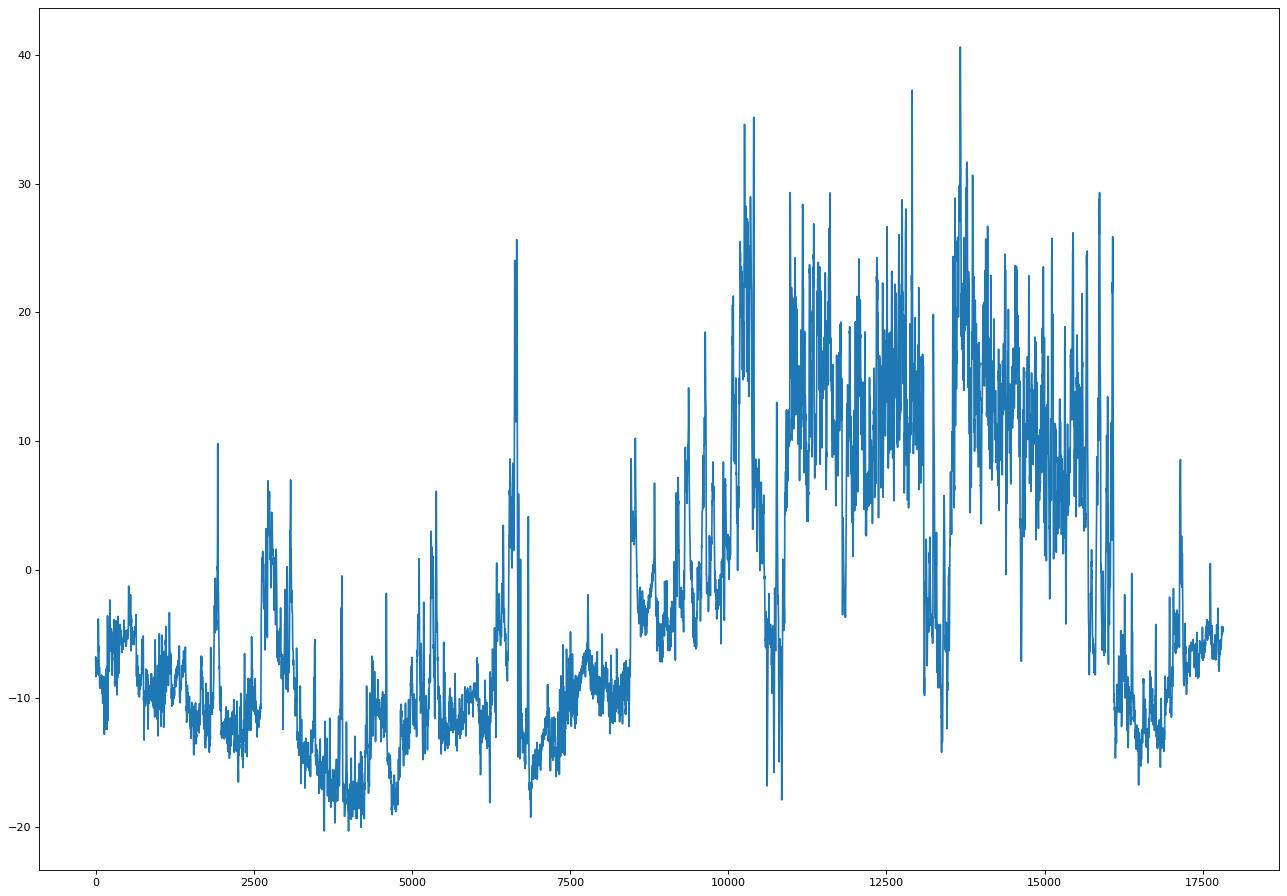

In [143]:
#detrending

from scipy import signal

detrended = signal.detrend(df2['heartrate'])

detrended_df = pd.DataFrame(detrended)

df_copy = df2.copy()

df_copy['heartrate'] = detrended_df

df_copy.head()


start_date = '2024-02-10'
end_date ='2024-02-14'
df_select = data_mask(df_copy,start_date,end_date)
df_select.head()

from matplotlib.pyplot import figure

figure(figsize=(20, 14), dpi=80)
df_select.heartrate.plot()






<AxesSubplot: >

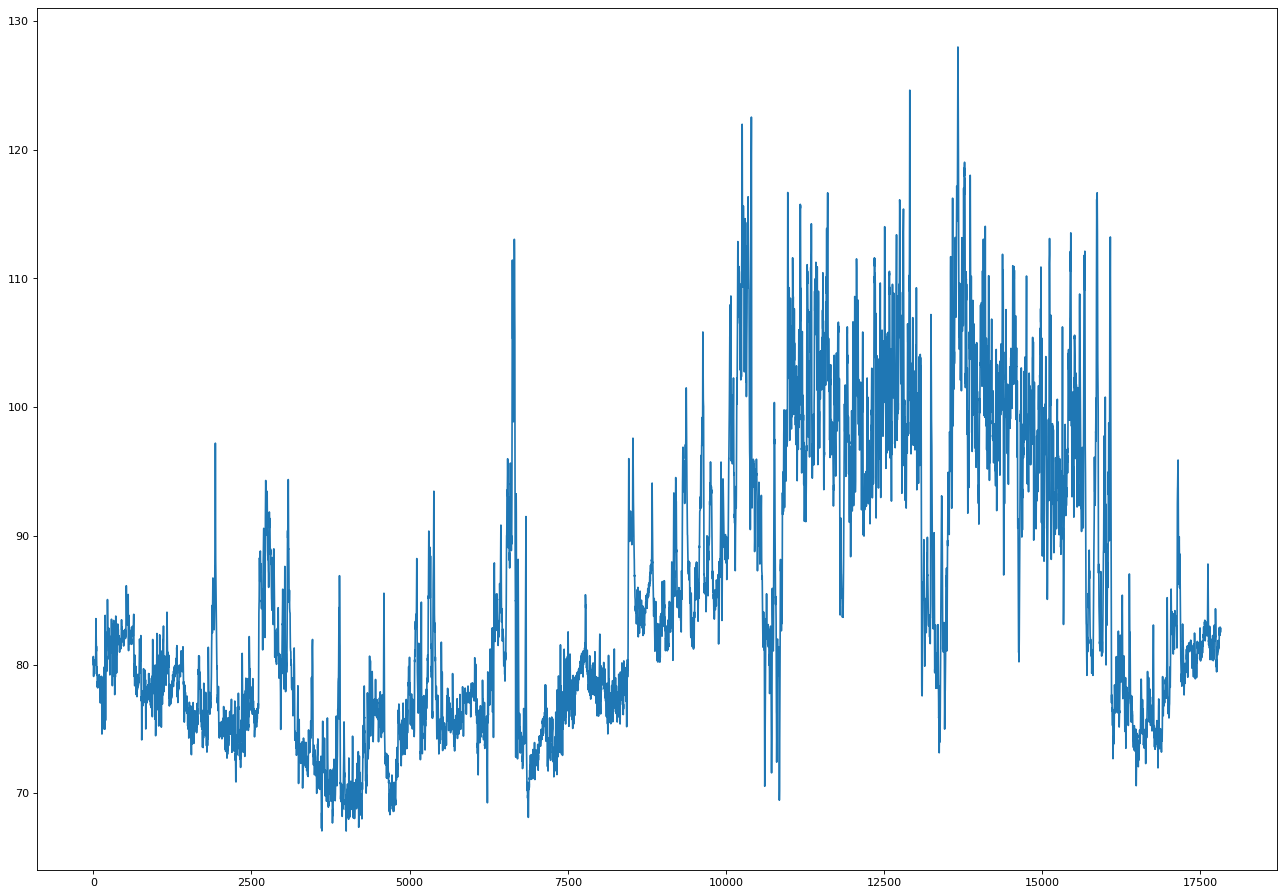

In [144]:
# deseasonalizing

from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df2['heartrate'], model='multiplicative',extrapolate_trend='freq', period=1)


detrended = res.resid + res.trend

detrended_df = pd.DataFrame(detrended)

df2_copy = df2.copy()

df2_copy['heartrate'] = detrended_df

df2_copy.head()

start_date = '2024-02-10'
end_date ='2024-02-14'
df_sel = data_mask(df2_copy,start_date,end_date)


from matplotlib.pyplot import figure

figure(figsize=(20, 14), dpi=80)
df_sel.heartrate.plot()


In [ ]:
# detrending and deseaonalizing give similar shapes with different value ranges